# CMIP6 wind along the continental slope

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import netCDF4 as nc
import numpy as np
import scipy.stats as st
import xarray as xr
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

figdir = '/home/561/jn8053/g_e14/figures-tmp/'

clnt = dsk.Client()
clnt

Client Scheduler: tcp://127.0.0.1:39965 Dashboard: /proxy/41391/status,Cluster Workers: 6 Cores: 24 Memory: 155.69 GB


In [2]:
# Font size
plt.rcParams['font.size'] = 16
# Axes
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
# Saving parameters
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

def change_lon_space(ds, grid):
    if grid == 'u':
        ds = ds.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
        ds['_lon_adj'] = xr.where(ds['lon'] < 0, ds['lon'] + 360, ds['lon'])
        ds = ds.swap_dims({'lon': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('lon')
        ds = ds.rename({'_lon_adj': 'lon'})
    elif grid == 't':
        ds = ds.rename(({'xt_ocean':'lon', 'yt_ocean':'lat'}))
        ds['_lon_adj'] = xr.where(ds['lon'] < 0, ds['lon'] + 360, ds['lon'])
        ds = ds.swap_dims({'lon': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('lon')
        ds = ds.rename({'_lon_adj': 'lon'})
    return ds

def extract_so(ds):
    ds_so = ds.sel(lat = slice(None, -50))
    return ds_so

def figure_along_slope():
    
    fig, axs = plt.subplots(figsize = (15, 5))
    axs.set_xlim(0, 360);
    axs.set_xticks(np.arange(0, 400, 50))
    axs.set_yticks(np.arange(-80, -55, 5))
    axs.set_xlabel('Longitude')
    axs.set_ylabel('Latitude')
    
    return fig, axs

## Create 1000m isobath mask and topographic gradient

In [51]:
hu = xr.open_dataset('/scratch/e14/jn8053/misc/hu-01deg.nc')['hu']
dhu_dx = hu.diff('xu_ocean')
dhu_dy = hu.diff('yu_ocean')
dhu_dx = dhu_dx.interp(xu_ocean = dhu_dy['xu_ocean'])

# Select latitude slice
lat_slice = slice(-80, -59)
dhu_dx = dhu_dx.sel(yu_ocean=lat_slice)
dhu_dy = dhu_dy.sel(yu_ocean=lat_slice)

# Magnitude of the topographic slope (to normalise the topographic gradient)
topographic_slope_magnitude = np.sqrt(dhu_dx**2 + dhu_dy**2)
dhu_dx = change_lon_space(dhu_dx)
dhu_dy = change_lon_space(dhu_dy)
topographic_slope_magnitude = change_lon_space(topographic_slope_magnitude)

dhu_dx = dhu_dx/topographic_slope_magnitude
dhu_dy = dhu_dy/topographic_slope_magnitude

topograd = xr.Dataset({'dhu_dx':dhu_dx, 'dhu_dy':dhu_dy})
topograd.to_netcdf('/scratch/e14/jn8053/misc/SO_topograd.nc')

# Create a 1000m isobath mask
contour_file = np.load('/scratch/e14/jn8053/misc/Antarctic_slope_contour_hu_1000m.npz')
shelf_mask = contour_file['contour_mask_numbered']
xu_ocean = contour_file['xu_ocean']
yu_ocean = contour_file['yu_ocean']
shelf_mask[shelf_mask != 0] = 1
shelf_mask[shelf_mask == 0] = np.nan
shelf_mask_array = xr.DataArray(shelf_mask, dims = ['yu_ocean', 'xu_ocean'], coords = {'yu_ocean':yu_ocean, 'xu_ocean':xu_ocean})
shelf_mask_array = change_lon_space(shelf_mask_array)
shelf_mask_array.to_netcdf('/scratch/e14/jn8053/misc/Antarctic_slope_mask.nc')

## Historical (1958 - 2015)

### Load `uas` and `vas`

In [3]:
# JRA55do-v14
uas_jra = xr.open_dataset('/scratch/e14/jn8053/jra55/uas-v14-monthly-1958_2019.nc').sel(lat = slice(None, -50)).sel(time = slice('1958-01-01', '2015-01-01'))
vas_jra = xr.open_dataset('/scratch/e14/jn8053/jra55/vas-v14-monthly-1958_2019.nc').sel(lat = slice(None, -50)).sel(time = slice('1958-01-01', '2015-01-01'))

# CMIP6 multimodel mean
uas_cmip_mmm = xr.open_dataset('/scratch/e14/jn8053/cmip6/historical/uas_historical_ensmean.nc')
vas_cmip_mmm = xr.open_dataset('/scratch/e14/jn8053/cmip6/historical/vas_historical_ensmean.nc')

# CMIP6 individual models
path_uas = glob.glob('/scratch/e14/jn8053/cmip6/historical/uas/*')
path_vas = glob.glob('/scratch/e14/jn8053/cmip6/historical/vas/*')
uas_cmip = {}
vas_cmip = {}
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0]
    uas_cmip[model_name] = xr.open_dataset(path_uas[i])
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0]
    vas_cmip[model_name] = xr.open_dataset(path_vas[i])
model_names = list(uas_cmip.keys())

### Along slope wind

Distance coordinate (Adele Morrison's code, only run once)

In [49]:
# extract dxt/dyt along contour:
num_points = 5936 # Adele had 6002 but I've changed it to match my shelf mask
north_index = 510
gridFile = xr.open_dataset('/g/data/v45/akm157/model_data/mom01_unmasked_ocean_grid.nc')
dxu = gridFile['dxu'][...]
dyt = gridFile['dyt'][:north_index,:]
xt_ocean = gridFile['xt_ocean'][...]
yt_ocean = gridFile['yt_ocean'][...]
lon_t = gridFile['geolon_t'][:north_index,...]
lat_t = gridFile['geolat_t'][:north_index,...]

# if there is a bend in the contour, add the distance using length of diagonal, not sum of
# 2 edges, to be more representative.
contour_depth = 1000
data = np.load('/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_1000m.npz')
mask_y_transport_numbered = data['mask_y_transport_numbered']
mask_x_transport_numbered = data['mask_x_transport_numbered']
contour_masked_above = data['contour_masked_above']

lon_along_contour = np.zeros((num_points))
lat_along_contour = np.zeros((num_points))
distance_along_contour = np.zeros((num_points))
x_indices = np.sort(mask_x_transport_numbered[mask_x_transport_numbered>0])
y_indices = np.sort(mask_y_transport_numbered[mask_y_transport_numbered>0])
skip = False

for count in range(1, num_points):
    if skip == True:
        skip = False
        continue
        
    if count in y_indices:
        if count + 1 in y_indices:
            # note dxu and dyt do no vary in x:
            jj = np.where(mask_y_transport_numbered == count)[0]
            # me added
            kk = np.where(mask_y_transport_numbered == count)[1]
            # ----
            distance_along_contour[count-1] = (dxu[jj,990])[0]
            lon_along_contour[count-1] = lon_t[0, kk]
            lat_along_contour[count-1] = lat_t[jj, 990]
        else:
            jj0 = np.where(mask_y_transport_numbered == count)[0]
            jj1 = np.where(mask_x_transport_numbered == count+1)[0]
           
            # me added
            kk0 = np.where(mask_y_transport_numbered == count)[1]
            kk1 = np.where(mask_x_transport_numbered == count+1)[1]
            # --
            diagonal_distance = 0.5*np.sqrt((dxu[jj0,990])[0]**2+\
                (dyt[jj1,990])[0]**2)
            distance_along_contour[count-1] = diagonal_distance
            distance_along_contour[count] = diagonal_distance
           
            lon_along_contour[count-1] = lon_t[0, kk0]
            lat_along_contour[count-1] = lat_t[jj0, 990]
            lon_along_contour[count] = lon_t[0, kk1]
            lat_along_contour[count] = lat_t[jj0, 990]
            # skip to next count:
            skip = True
    # count in x_indices:
    else:
        if count + 1 in x_indices:
            jj = np.where(mask_x_transport_numbered == count)[0]
            # me added
            kk = np.where(mask_x_transport_numbered == count)[1]
            # ----
            distance_along_contour[count-1] = (dyt[jj,990])[0]
            lon_along_contour[count-1] = lon_t[0, kk]
            lat_along_contour[count-1] = lat_t[jj, 990]
        else:
            jj0 = np.where(mask_x_transport_numbered == count)[0]
            jj1 = np.where(mask_y_transport_numbered == count+1)[0]
           
            # me added
            kk0 = np.where(mask_x_transport_numbered == count)[1]
            kk1 = np.where(mask_y_transport_numbered == count+1)[1]
            # --
            diagonal_distance = 0.5*np.sqrt((dyt[jj0,990])[0]**2+\
                (dxu[jj1,990])[0]**2)
            distance_along_contour[count-1] = diagonal_distance
            distance_along_contour[count] = diagonal_distance
           
            lon_along_contour[count-1] = lon_t[0, kk0]
            lat_along_contour[count-1] = lat_t[jj0, 990]
            lon_along_contour[count] = lon_t[0, kk1]
            lat_along_contour[count] = lat_t[jj0, 990]
           
            # skip to next count:
            skip = True
           
           
# fix last value:
if distance_along_contour[-1] == 0:
    count = count + 1
    if count in y_indices:
        jj = np.where(mask_y_transport_numbered == count)[0]
        #kk = np.where(mask_y_transport_numbered==count)[1]
        distance_along_contour[-1] = (dxu[jj, 990])[0]
        #lon_along_contour[count-1] = lon_t[0, kk]
        #lat_along_contour[count-1] = lat_t[jj, 990]
    else:
        jj = np.where(mask_x_transport_numbered==count)[0]
        #kk = np.where(mask_x_transport_numbered==count)[1]
        distance_along_contour[-1] = (dyt[jj,990])[0]
        #lon_along_contour[count-1] = lon_t[0, kk]
        #lat_along_contour[count-1] = lat_t[jj, 990]

# units are 10^3 km:
distance_along_contour = np.cumsum(distance_along_contour)/1e3/1e3

# Change from -270:80 to 0:360

np.where(lon_along_contour == np.min(np.abs(lon_along_contour)))

distance1 = distance_along_contour[4797:] - distance_along_contour[4797]
distance2 = distance_along_contour[:4797] + distance_along_contour[-1] - distance_along_contour[4797]
lon1 = lon_along_contour[4797:] 
lon2 = lon_along_contour[:4797] + 360
lat1 = lat_along_contour[4797:] 
lat2 = lat_along_contour[:4797] 

distance_coord = xr.Dataset({'distance':np.concatenate([distance1, distance2]),
                             'lon': np.concatenate([lon1, lon2]),
                             'lat':np.concatenate([lat1, lat2])})
distance_coord.to_netcdf('~/g_e14/Antarctic_distance_along_1000m.nc')

In [77]:
topograd = xr.open_dataset('/scratch/e14/jn8053/misc/SO_topograd.nc')
shelfmsk = xr.open_dataset('/scratch/e14/jn8053/misc/Antarctic_slope_mask.nc')['__xarray_dataarray_variable__']
distance = xr.open_dataset('~/g_e14/Antarctic_distance_along_1000.nc')

In [24]:
# Only run this once
model_names = list(vas_cmip.keys())
u_flat_cmip_ind = {}
for i in range(0, len(model_names)):
    
    # Along-slope velocity 
    uas_int = uas_cmip[model_names[i]].interp(lon = topograd['lon'], lat = topograd['lat'])
    uas_int['time'] = uas_jra['time'].values
    vas_int = vas_cmip[model_names[i]].interp(lon = topograd['lon'], lat = topograd['lat'])
    vas_int['time'] = uas_jra['time'].values
    u_along_cmip_ind = uas_int['uas']*topograd['dhu_dy'] - vas_int['vas']*topograd['dhu_dx']
    
    u_flat_cmip_ind[model_names[i]] = np.empty([684, N])
    for ii in range(N):
        xx = distance['lon'][ii]
        yy = distance['lat'][ii]
        u_flat_cmip_ind[model_names[i]][:, ii] = u_along_cmip_ind.sel(lon = slice(xx-0.5, xx+0.5), lat = slice(yy-0.5, yy+0.5)).mean(['lon', 'lat']).values
    u_flat_cmip_ind[model_names[i]] = xr.DataArray(u_flat_cmip_ind[model_names[i]], dims = ['time', 'distance'], 
                                                   coords = {'time':uas_jra['time'], 'distance':distance['distance']})
    u_flat_cmip_ind[model_names[i]].to_netcdf('/scratch/e14/jn8053/cmip6/historical/wind_vs_distance/wind-'+model_names[i]+'.nc')

In [80]:
u_flat_cmip_ind = {}
for i in range(0, len(model_names)):
    u_flat_cmip_ind[model_names[i]] = xr.open_dataset('/scratch/e14/jn8053/cmip6/historical/wind_vs_distance/wind-'+model_names[i]+'.nc')['__xarray_dataarray_variable__']

In [81]:
# Along-slope velocity JRA mean
uas_int = uas_jra.interp(lon = topograd['lon'], lat = topograd['lat'])
vas_int = vas_jra.interp(lon = topograd['lon'], lat = topograd['lat'])
u_along_jra = uas_int['uas']*topograd['dhu_dy'] - vas_int['vas']*topograd['dhu_dx']
u_along_jra_1000 = u_along_jra.mean('time')*shelfmsk

N = len(distance['distance'])
u_flat_jra = np.empty([684, N])
for i in range(N):
    xx = distance['lon'][i]
    yy = distance['lat'][i]
    u_flat_jra[:, i] = u_along_jra.sel(lon = slice(xx-0.5, xx+0.5), lat = slice(yy-0.5, yy+0.5)).mean(['lon', 'lat']).values
u_flat_jra = xr.DataArray(u_flat_jra, dims = ['time', 'distance'], coords = {'time':uas_jra['time'], 'distance':distance['distance']})

# Along-slope velocity CMIP ensmean
uas_int = uas_cmip_mmm.interp(lon = topograd['lon'], lat = topograd['lat'])
uas_int['time'] = uas_jra['time'].values # Fix different calendar conventions
vas_int = vas_cmip_mmm.interp(lon = topograd['lon'], lat = topograd['lat'])
vas_int['time'] = uas_jra['time'].values
u_along_cmip = uas_int['uas']*topograd['dhu_dy'] - vas_int['vas']*topograd['dhu_dx']
u_along_cmip_1000 = u_along_cmip.mean('time')*shelfmsk

N = len(distance['distance'])
u_flat_cmip = np.empty([684, N])
for i in range(N):
    xx = distance['lon'][i]
    yy = distance['lat'][i]
    u_flat_cmip[:, i] = u_along_cmip.sel(lon = slice(xx-0.5, xx+0.5), lat = slice(yy-0.5, yy+0.5)).mean(['lon', 'lat']).values
u_flat_cmip = xr.DataArray(u_flat_cmip, dims = ['time', 'distance'], coords = {'time':uas_jra['time'], 'distance':distance['distance']})

In [33]:
region_divides = [1016, 1615, 2179, 3733, 4353, 4783]

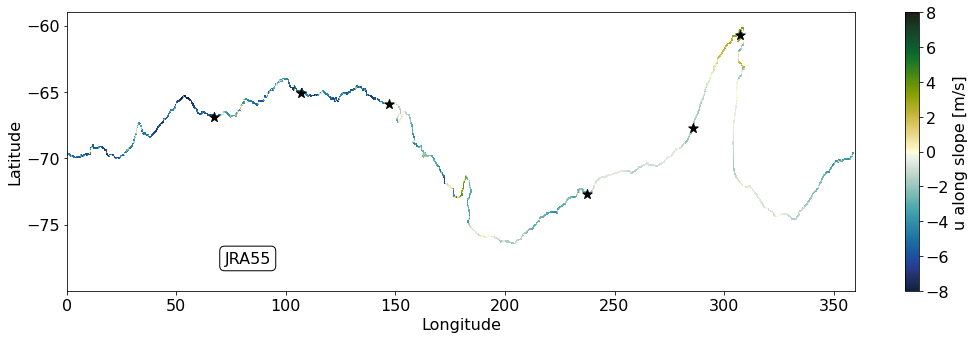

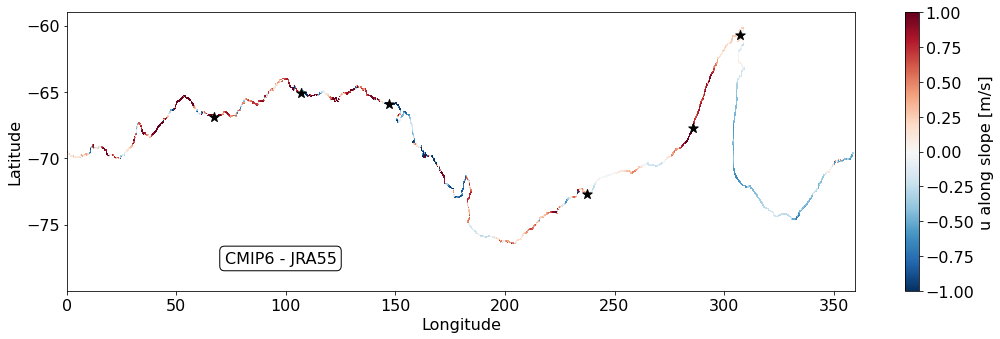

In [36]:
fig, axs = figure_along_slope()
cf = axs.pcolormesh(u_along_jra['lon'], u_along_jra['lat'], u_along_jra_1000,
                    vmin = -8, vmax = 8, cmap = cmocean.cm.delta)
axs.scatter(distance['lon'][region_divides], distance['lat'][region_divides], s = 100, c = 'k', marker = '*')
axs.text(0.2, 0.1, 'JRA55', transform = axs.transAxes, bbox = dict(boxstyle = 'round', facecolor = 'white'))
cbar = fig.colorbar(cf, ax = axs, orientation = 'vertical')
cbar.set_label('u along slope [m/s]')
plt.tight_layout()
plt.savefig(figdir+'/easterlies/historical/u_along_mean_jra55.png', facecolor = 'white', bbox_inches = 'tight')

fig, axs = figure_along_slope()
cf = axs.pcolormesh(u_along_cmip['lon'], u_along_cmip['lat'], u_along_cmip_1000 - u_along_jra_1000,
                    vmin = -1, vmax = 1, cmap = 'RdBu_r')
axs.scatter(distance['lon'][region_divides], distance['lat'][region_divides], s = 100, c = 'k', marker = '*')
axs.text(0.2, 0.1, 'CMIP6 - JRA55', transform = axs.transAxes, bbox = dict(boxstyle = 'round', facecolor = 'white'))
cbar = fig.colorbar(cf, ax = axs, orientation = 'vertical')
cbar.set_label('u along slope [m/s]')
plt.tight_layout()
plt.savefig(figdir+'/easterlies/historical/u_along_mean_cmip6-jra55.png', facecolor = 'white', bbox_inches = 'tight')

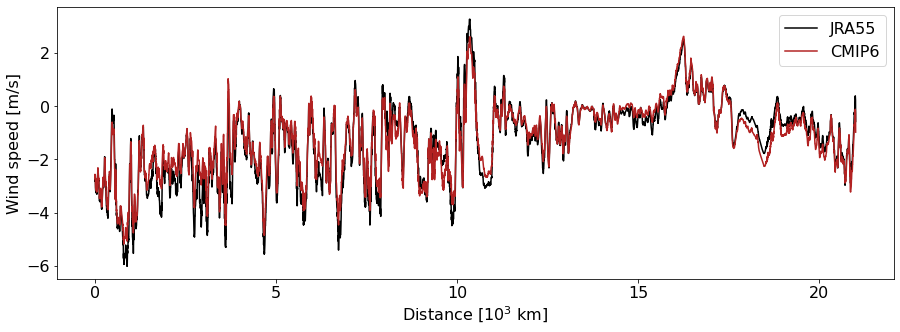

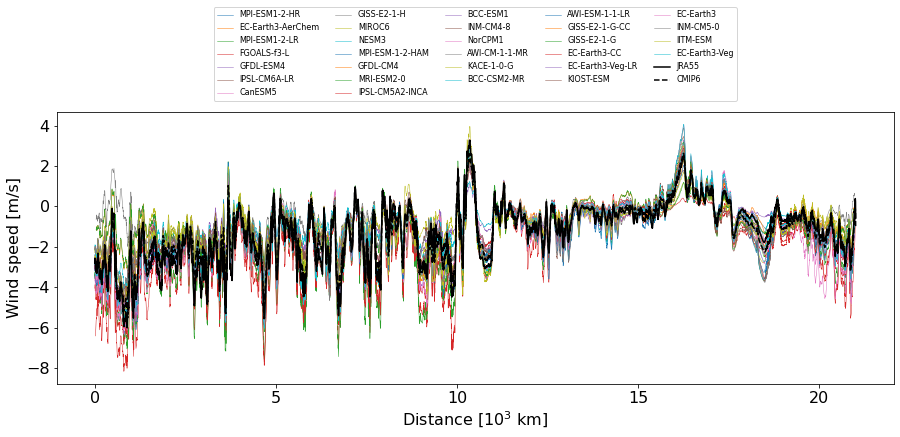

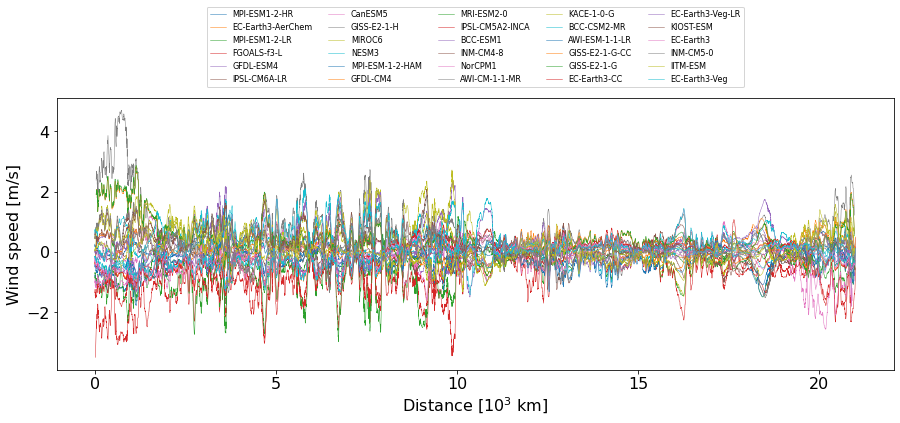

In [31]:
plt.figure(figsize = (15, 5))
plt.plot(u_flat_jra['distance'], u_flat_jra, 'k', label = 'JRA55')
plt.plot(u_flat_cmip['distance'], u_flat_cmip, 'firebrick', label = 'CMIP6')
plt.ylabel('Wind speed [m/s]')
plt.xlabel('Distance [10$^{3}$ km]')
plt.legend()
plt.savefig(figdir+'/easterlies/historical/wind_distance_cmip6mmm-jra55.png', facecolor = 'white', bbox_inches = 'tight')

fig, axs = plt.subplots(figsize = (15, 5))
for i in range(0, len(model_names)):
    axs.plot(u_flat_cmip_ind[model_names[i]]['distance'], u_flat_cmip_ind[model_names[i]].mean('time'), linewidth = 0.5, label = model_names[i])    
axs.plot(u_flat_jra['distance'], u_flat_jra, 'k', linewidth = 1.5, label = 'JRA55')
axs.plot(u_flat_cmip['distance'], u_flat_cmip, 'k', linestyle = '--', linewidth = 1.5, label = 'CMIP6')
axs.set_ylabel('Wind speed [m/s]')
axs.set_xlabel('Distance [10$^{3}$ km]')
plt.legend(ncol = 5, bbox_to_anchor = (0.5, 1.4), loc = 'upper center', fontsize = 8)
plt.savefig(figdir+'/easterlies/historical/wind_distance_cmip6ind-jra55.png', facecolor = 'white', bbox_inches = 'tight')

fig, axs = plt.subplots(figsize = (15, 5))
for i in range(0, len(model_names)):
    axs.plot(u_flat_cmip_ind[model_names[i]]['distance'], u_flat_cmip_ind[model_names[i]].mean('time') - u_flat_cmip, linewidth = 0.5, label = model_names[i])    
axs.set_ylabel('Wind speed [m/s]')
axs.set_xlabel('Distance [10$^{3}$ km]')
plt.legend(ncol = 5, bbox_to_anchor = (0.5, 1.35), loc = 'upper center', fontsize = 8)
plt.savefig(figdir+'/easterlies/historical/wind_distance_cmip6ind-cmip6.png', facecolor = 'white', bbox_inches = 'tight')

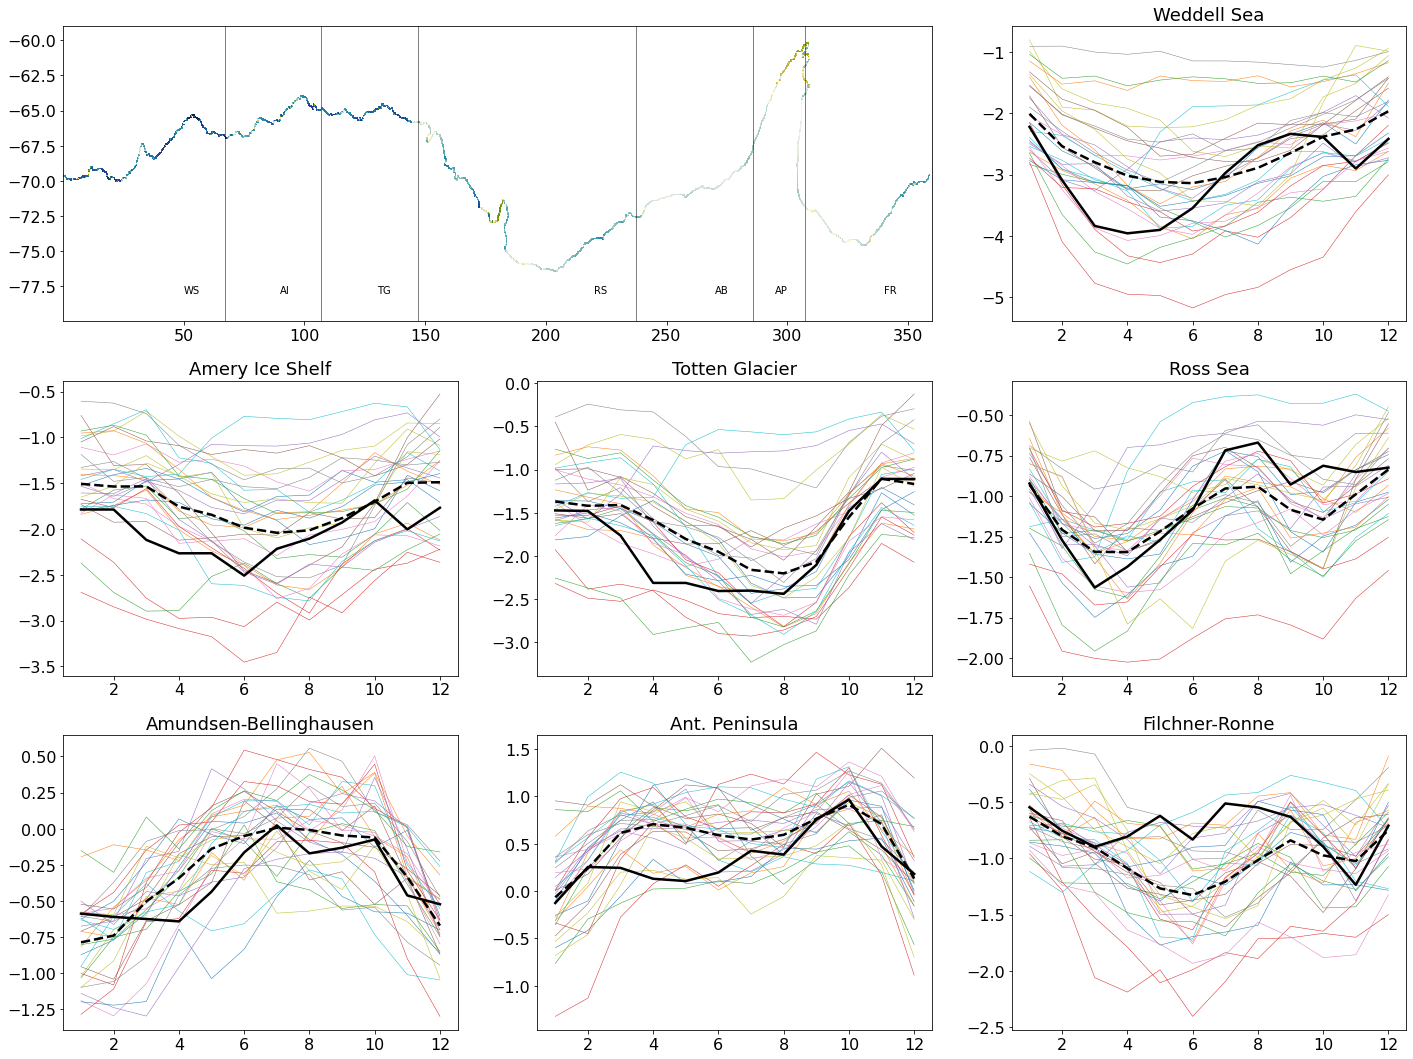

In [84]:
fig = plt.figure(figsize = (20, 15))
gd = gs.GridSpec(3, 3, figure = fig)
ax1 = fig.add_subplot(gr[0,:-1])
ax2 = fig.add_subplot(gr[0,2])
ax3 = fig.add_subplot(gr[1,0])
ax4 = fig.add_subplot(gr[1,1])
ax5 = fig.add_subplot(gr[1,2])
ax6 = fig.add_subplot(gr[2,0])
ax7 = fig.add_subplot(gr[2,1])
ax8 = fig.add_subplot(gr[2,2])

for i in region_divides:
    ax1.axvline(x = distance['lon'][i], color = 'k', linewidth = .5)
ax1.text(50, -78, 'WS', fontsize = 10)
ax1.text(90, -78, 'AI', fontsize = 10)
ax1.text(130, -78, 'TG', fontsize = 10)
ax1.text(220, -78, 'RS', fontsize = 10)
ax1.text(270, -78, 'AB', fontsize = 10)
ax1.text(295, -78, 'AP', fontsize = 10)
ax1.text(340, -78, 'FR', fontsize = 10)

ax1.pcolormesh(u_along_jra['lon'], u_along_jra['lat'], u_along_jra_1000,
                    vmin = -8, vmax = 8, cmap = cmocean.cm.delta)

for i in range(0, len(model_names)):
    ax2.plot(np.arange(1, 13, 1), u_flat_cmip_ind[model_names[i]].sel(distance = slice(0, 3.2)).mean('distance').groupby('time.month').mean('time'), 
             linewidth = 0.5, label = model_names[i])    
    ax3.plot(np.arange(1, 13, 1), u_flat_cmip_ind[model_names[i]].sel(distance = slice(3.2, 5.9)).mean('distance').groupby('time.month').mean('time'), 
             linewidth = 0.5, label = model_names[i]) 
    ax4.plot(np.arange(1, 13, 1), u_flat_cmip_ind[model_names[i]].sel(distance = slice(5.9, 8.1)).mean('distance').groupby('time.month').mean('time'), 
             linewidth = 0.5, label = model_names[i]) 
    ax5.plot(np.arange(1, 13, 1), u_flat_cmip_ind[model_names[i]].sel(distance = slice(8.1, 13)).mean('distance').groupby('time.month').mean('time'), 
             linewidth = 0.5, label = model_names[i]) 
    ax6.plot(np.arange(1, 13, 1), u_flat_cmip_ind[model_names[i]].sel(distance = slice(13, 15.1)).mean('distance').groupby('time.month').mean('time'), 
             linewidth = 0.5, label = model_names[i]) 
    ax7.plot(np.arange(1, 13, 1), u_flat_cmip_ind[model_names[i]].sel(distance = slice(15.1, 16.8)).mean('distance').groupby('time.month').mean('time'), 
             linewidth = 0.5, label = model_names[i]) 
    ax8.plot(np.arange(1, 13, 1), u_flat_cmip_ind[model_names[i]].sel(distance = slice(16.8, None)).mean('distance').groupby('time.month').mean('time'), 
             linewidth = 0.5, label = model_names[i]) 
ax2.plot(np.arange(1, 13, 1), u_flat_jra.sel(distance = slice(0, 3.2)).mean('distance').groupby('time.month').mean('time'), 
         color = 'k', linewidth = 2.5, label = 'JRA55-do')
ax2.plot(np.arange(1, 13, 1), u_flat_cmip.sel(distance = slice(0, 3.2)).mean('distance').groupby('time.month').mean('time'), 
         color = 'k', linewidth = 2.5, linestyle = '--', label = 'CMIP6 mean')
ax2.set_title('Weddell Sea', fontsize = 18)
ax3.plot(np.arange(1, 13, 1), u_flat_jra.sel(distance = slice(3.2, 5.9)).mean('distance').groupby('time.month').mean('time'), 
         color = 'k', linewidth = 2.5, label = 'JRA55-do')
ax3.plot(np.arange(1, 13, 1), u_flat_cmip.sel(distance = slice(3.2, 5.9)).mean('distance').groupby('time.month').mean('time'), 
         color = 'k', linewidth = 2.5, linestyle = '--', label = 'CMIP6 mean')
ax3.set_title('Amery Ice Shelf', fontsize = 18)
ax4.plot(np.arange(1, 13, 1), u_flat_jra.sel(distance = slice(5.9, 8.1)).mean('distance').groupby('time.month').mean('time'), 
         color = 'k', linewidth = 2.5, label = 'JRA55-do')
ax4.plot(np.arange(1, 13, 1), u_flat_cmip.sel(distance = slice(5.9, 8.1)).mean('distance').groupby('time.month').mean('time'), 
         color = 'k', linewidth = 2.5, linestyle = '--', label = 'CMIP6 mean')
ax4.set_title('Totten Glacier', fontsize = 18)
ax5.plot(np.arange(1, 13, 1), u_flat_jra.sel(distance = slice(8.1, 13)).mean('distance').groupby('time.month').mean('time'), 
         color = 'k', linewidth = 2.5, label = 'JRA55-do')
ax5.plot(np.arange(1, 13, 1), u_flat_cmip.sel(distance = slice(8.1, 13)).mean('distance').groupby('time.month').mean('time'), 
         color = 'k', linewidth = 2.5, linestyle = '--', label = 'CMIP6 mean')
ax5.set_title('Ross Sea', fontsize = 18)
ax6.plot(np.arange(1, 13, 1), u_flat_jra.sel(distance = slice(13, 15.1)).mean('distance').groupby('time.month').mean('time'), 
         color = 'k', linewidth = 2.5, label = 'JRA55-do')
ax6.plot(np.arange(1, 13, 1), u_flat_cmip.sel(distance = slice(13, 15.1)).mean('distance').groupby('time.month').mean('time'), 
         color = 'k', linewidth = 2.5, linestyle = '--', label = 'CMIP6 mean')
ax6.set_title('Amundsen-Bellinghausen', fontsize = 18)
ax7.plot(np.arange(1, 13, 1), u_flat_jra.sel(distance = slice(15.1, 16.8)).mean('distance').groupby('time.month').mean('time'), 
         color = 'k', linewidth = 2.5, label = 'JRA55-do')
ax7.plot(np.arange(1, 13, 1), u_flat_cmip.sel(distance = slice(15.1, 16.8)).mean('distance').groupby('time.month').mean('time'), 
         color = 'k', linewidth = 2.5, linestyle = '--', label = 'CMIP6 mean')
ax7.set_title('Ant. Peninsula', fontsize = 18)
ax8.plot(np.arange(1, 13, 1), u_flat_jra.sel(distance = slice(16.8, None)).mean('distance').groupby('time.month').mean('time'), 
         color = 'k', linewidth = 2.5, label = 'JRA55-do')
ax8.plot(np.arange(1, 13, 1), u_flat_cmip.sel(distance = slice(16.8, None)).mean('distance').groupby('time.month').mean('time'), 
         color = 'k', linewidth = 2.5, linestyle = '--', label = 'CMIP6 mean')
ax8.set_title('Filchner-Ronne', fontsize = 18)
plt.tight_layout()
plt.savefig(figdir+'/easterlies/historical/wind_along-regional-seasonal.png', facecolor = 'white', bbox_inches = 'tight')